## Principal Component Analysis Introduction

Principal component analysis is a technique in data science that finds an optimal, alternate and often reduced representation of high-dimensional data. Optimal in the context of PCA means that the coordinates of the data in the transformed basis capture the greatest variability in the data.

As a simple example, we can consider a dataset comprised of $2\times2$ images. In this representation, each image is described by $2\times2\times3=12$ coordinates corresponding to the values of each pixels' red, green, and blue channels. We refer to this as the image basis. The first basis vector in the image basis is:
![vector](figures/vector.png)
The set of all twelve basis vectors in this example can be visualized below:
![basis](figures/image_basis.png)

Principal component analysis involves a change of basis; rather than characterizing each image by a set of coordinates representing pixel RGB channels, the image can be suitably represented in a new basis of principal axes, which is typically smaller than the initial number of coordinates. 

Each principal axis is some linear combination of the image basis vectors, formed so that the coordinate of the images along the first principal axis - their first principal component - has the largest variance. The second principal axis is chosen such that the second principal component has the next largest possible variance while maintaining that the second and first principal axes are orthogonal, and so on.

A common application of principal component analysis is dimensionality reduction, as principal components are sorted to express as much variability in the data as possible. We will use animation to illustrate how principal component analysis can be used to reconstruct an image with considerably less information needed.

As our test image dataset, we have collected images of Vincent van Gogh's portrait artwork, cropped to a uniform $136\times136$ pixel region - an image basis of $136\times136\times3=55488$ basis vectors! All images are obtained from [vincentvangogh.org](https://www.vincentvangogh.org/), which hosts a gallery of van Gogh's works.

## Code and Animation
We begin by defining a short routine to load all image data:

In [1]:
from matplotlib.pyplot import imread
import glob
import numpy as np

def load_data(ddir, ext):
    ''' read in all image files in directory ddir with specified extension
        into a numpy array of shape (N, m, n, p), where N is number of samples,
        m x n is the image dimension, and p is the number of channels.'''
    print("loading data ...")
    files = sorted(glob.glob(ddir+"*."+ext))
    for i,f in enumerate(files):
        if i==0:
            im = imread(f)
            m, n, p = im.shape
            im = im.reshape(1, m, n, p)
        else:
            im = np.append(im,imread(f).reshape(1, m, n, p), axis=0)
    if ext=="jpg":
        im = im.astype(np.float)/255. # convert to [0,1] scale
    print("load complete!")
    return im

In [2]:
# load the data of van Gogh's portraits
data = load_data("../vg_data/","jpg")

loading data ...
load complete!


Next, using [`scikit-learn`'s PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA) class, we fit the principal axes of our dataset, which includes $116$ images.

In [3]:
from sklearn.decomposition import PCA

N, m, n, p = data.shape
pca = PCA(svd_solver='full')     # svd_solver='full' means run the full SVD via scipy.linalg.svd
pca.fit(data.reshape(N, m*n*p))  # fit principal axes to our data

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

Our goal is to reconstruct an image from our dataset with a limited number of principal components, and visualize its refinement as more components are introduced. To do this, we transform the image into the basis of principal axes, retain a specified number of components, and transform back into the original image basis. An image in the transformed basis can be obtained with the `transform` method of the `pca` object, and the change of basis transformation matrix is given by the `components_` attribute.

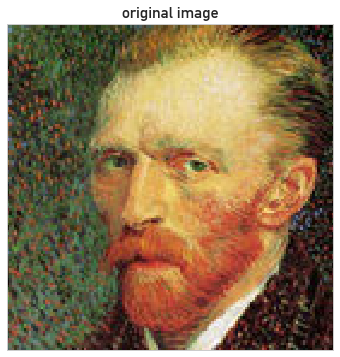

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib
matplotlib.rc('font',family='DIN Alternate')

# select a sample image from the dataset
image_ID = 104
im_b = data[image_ID,:]

# compute the image representation in the basis of principal axes
pca_b = pca.transform(im_b.reshape((1,-1)))

# compute the data mean, for inverse transform
mu = np.mean(data.reshape(N, m*n*p), axis=0).reshape(m, n, p)

# view the original image
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.imshow(im_b)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("original image", size=16)
plt.show()

Next we prepare our animations. We have selected one representative image to reconstruct, and plot its cumulative refinement with the addition of more principal components.

In addition, we seek to further elucidate the relationship between the image basis and basis of principal axes. Since each principal axis is some linear combination of image basis vectors, we can visualize the projection of the principal axes back onto the image space.

As noted, the principal axes are chosen such that the variance of the data along each axis is as large as possible. The total variance captured by each principal axis is quantified by the explained variance. We lastly track the cumulative explained variance ratio, whose sum across all principal axes is one, as a metric of how much variability in the data has been accounted for.

In [5]:
# animation setup: Refs 4 and 5 cited at the end were used as a general guide.

frames = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,60,70,80,90,100]
def get_images(ncomp):
    '''Image reconstruction in original image space using the first ncomp principal components.
       Also returns the representation of the ncomp-1 principal axis in image space.'''
    # reconstructed image
    data = mu + np.dot(pca_b[0,:ncomp],pca.components_[:ncomp,:]).reshape(m, n, p)
    data[data<0]=0
    data[data>1]=1
    # principal axes projected onto the image space
    pax = pca.components_[ncomp-1,:].reshape((m,n,p))
    red_pax = pax[:,:,0]
    green_pax = pax[:,:,1]
    blue_pax = pax[:,:,2]
    
    return data, red_pax, green_pax, blue_pax

def get_evr(ncomp):
    '''Return cumulative explained variance ratio.'''
    return np.arange(ncomp+1), np.hstack([0,pca.explained_variance_ratio_[:ncomp].cumsum()])

In [6]:
# initialize figure
fig = plt.figure(figsize=(10,10))
grid = plt.GridSpec(3, 3, wspace=0.1, hspace=0.1)
axr = fig.add_subplot(grid[:2,:2])     # reconstructed image plot
ax1 = fig.add_subplot(grid[0,2])       # principal axis projection: red channel
ax2 = fig.add_subplot(grid[1,2])       # principal axis projection: green channel
ax3 = fig.add_subplot(grid[2,2])       # principal axis projection: blue channel
axp = fig.add_subplot(grid[2,:2])      # explained variance ratio plot

# reconstructed image plot
im = axr.imshow(get_images(1)[0])
axr.set_title("reconstructed image", size=16)
axr.set_xticks([])
axr.set_yticks([])

# principal axis in image space
red_pax, green_pax, blue_pax = get_images(frames[-1])[1:]
pr = plt.imread("figures/portrait.png")
for ax in [ax1, ax2, ax3]:
    ax.imshow(pr)
    ax.yaxis.set_label_position("right")
    ax.set_xticks([])
    ax.set_yticks([])
cmap = 'inferno'
cf = ax1.contourf(red_pax, levels=3, cmap=cmap, alpha=0.6)
ax2.contourf(green_pax, levels=3, cmap=cmap, alpha=0.6)
ax3.contourf(blue_pax, levels=3, cmap=cmap, alpha=0.6)
fig.colorbar(cf, ax=ax1, orientation='vertical', fraction=0.046)
fig.colorbar(cf, ax=ax2, orientation='vertical', fraction=0.046)
fig.colorbar(cf, ax=ax3, orientation='vertical', fraction=0.046)

# cumulative explained variance ratio
x, y = get_evr(frames[-1])
axp.plot(x, y, color='teal', alpha=0.5, linestyle='dashed') # plot a static guiding curve
x, y = get_evr(1)
line, = axp.plot(x, y, color='orange', linewidth=4)         # plot updating curve
pt, = axp.plot(x[-1], y[-1], 'o', color='orange', linewidth=6)
axp.set_ylabel("cumulative explained\nvariance ratio", size=16)
axp.set_xlabel("Number of components", size=16)

def animate(i):
    '''Plot updates for animation.'''
    data, red_pax, green_pax, blue_pax = get_images(i)
    im.set_data(data) # update reconstructed image
    for ax in [ax1, ax2, ax3]:
        ax.clear() # clear axes for new plot; needed as contourf lacks set_data method.
        ax.imshow(pr)
        ax.yaxis.set_label_position("right")
        ax.set_xticks([])
        ax.set_yticks([])
    ax1.contourf(red_pax, levels=2, cmap=cmap, alpha=0.3)
    ax2.contourf(green_pax, levels=3, cmap=cmap, alpha=0.3)
    ax3.contourf(blue_pax, levels=3, cmap=cmap, alpha=0.3)
    ax1.set_title("Principal axis\nin image space", size=16)
    ax1.set_ylabel("red channel", size=16, rotation=270, labelpad=65, color='tomato')
    ax2.set_ylabel("green channel", size=16, rotation=270, labelpad=65, color='mediumseagreen')
    ax3.set_ylabel("blue channel", size=16, rotation=270, labelpad=65, color='royalblue')
    x, y = get_evr(i)
    line.set_xdata(x)
    line.set_ydata(y)
    pt.set_xdata(x[-1])
    pt.set_ydata(y[-1])
    # set a title for the figure as a whole
    if i==1:
        fig.suptitle('1 principal component',size=20)
    else:
        fig.suptitle(str(i)+' principal components',size=20)
    return im, line, pt,

ani = animation.FuncAnimation(fig, animate, frames=frames, interval=1000, blit=True, repeat_delay=10000)
plt.close(fig)

In [7]:
# Display the animation
HTML(ani.to_html5_video())

In [8]:
# save the animation
ani.save('../artifacts/jovanaandrejevic_artifact.gif', writer='imagemagick', fps=1)

## References

1. "Vincent van Gogh, his Life and Paintings." Vincent van Gogh Paintings, Drawings, Quotes, and Biography. [https://www.vincentvangogh.org/](https://www.vincentvangogh.org/).

2. VanderPlas, Jake. "In Depth: Principal Component Analysis." Python Data Science Handbook: Essential tools for working with data. " O'Reilly Media, Inc.", 2016. [https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html).

3. “Sklearn.decomposition.PCA.” Scikit-Learn 0.19.2 Documentation, [scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA](scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA).

4. Tiao, Louis. “Embedding Matplotlib Animations in Jupyter Notebooks.” Louis Tiao, 16 Apr. 2016, [louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/](louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/).

5. Tiao, Louis. “Save Matplotlib Animations as GIFs.” Louis Tiao, 4 Aug. 2016, [http://louistiao.me/posts/notebooks/save-matplotlib-animations-as-gifs/](http://louistiao.me/posts/notebooks/save-matplotlib-animations-as-gifs/).